In [1]:
%pip install scikit-learn
%pip install openpyxl
import sklearn
import pandas as pd
import numpy as np
%pip install rdkit
from rdkit import Chem
from rdkit.Chem import AllChem #got a deprecation warning from  AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
from rdkit.Chem import Descriptors
#from rdkit.ML.Descriptors import MoleculeDescriptors #not recommended for this assignment
#fingerprints is better; converts directly to binary
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from rdkit.Chem import rdFingerprintGenerator #switched to rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
from rdkit import DataStructs
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [2]:

def dataframe(sheet):
    data = pd.read_excel("data_PRE.xlsx", sheet_name=sheet) #loading data to Data Frame
    data=data[data['Smiles'].notna()]
    data=data[data['log (mmol/kg)'].notna()] #sourced from Youtube Build a Logistic Regression Model from START to FINISH with Scikit-Learn
    return data

def mol_smile(data):
    smiles_list = data.iloc[:,0]
    mols = [Chem.MolFromSmiles(s) for s in smiles_list] #converting the smiles to molecules for fingerprint generation
    return mols
#what is a fingerprint? a binary array aka bit vector corresponding to a molecule based on its chemical properties
#Morgan fingerprint generator from rdkit; morgan fingerprints perform circular vectorization to characterize the environment of each atom in the molecule (ie. other atoms bonded to it, local atomic structure, element type)
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024) 
#read that fp size is usually 1024 or 2048 and PredAOT used fpSize 2048; radius of 2 is the standard for searching (info within two bonds of the central atom)
# fpSize and radius values affect the test accuracy
    #for example, fpSize=2048 has 0.9897 accuracy and fpSize =1024 has accuracy of 0.9905; radius larger than two causes the accuracy to decrease, most likely due to overfitting or high sparsity (too many zeroes in the bit vector)

def all_vals(mols, data):
    fingerprints = []
    MWs=[]
    y_values=[]
    #creating an empty list for fingerprints, molecular weights (for ld50 conversion calculations), and ld50 log values
    #ran into issues with aligning indices when I did not set all indices from original Data Frame; also simplifies code
    for i, mol in enumerate(mols):
        if mol is not None:
            fp = gen.GetFingerprint(mol)  #generate fingerprint for each mol
            fingerprints.append(fp)
            mw = Descriptors.MolWt(mol) #obtain molecular weight from rdkit's descriptors
            MWs.append(mw)
            y_values.append(data.iloc[i, 1]) #appending valid log mmol/kg values 
    return fingerprints, MWs, y_values
        
def fp_to_array(fp):
    array = np.zeros((fp.GetNumBits(),), dtype=int) #creating an array with zeroes sized to the fingerprint bit length
    DataStructs.ConvertToNumpyArray(fp, array) #using rdkit's data structure conversion to create an array of binary values, which can be used to form a list
    return array.tolist()

def X_val(fingerprints):
    X = [fp_to_array(fp) for fp in fingerprints]
    return X

#valid_indices = [] #since the mols value has been filtered to create the X list, to match the indices to create y, this list need to be created
#for i, mol in enumerate(mols):
 #   if mol is not None:
  #      valid_indices.append(i)

#y_values= data_rats.iloc[valid_indices, 1]

def ld50s(y_values, MWs):
    ld50 = []
    for idx, value in enumerate(y_values): 
        tox = np.power(10, value) * MWs[idx] #conversion of log mmol/kg to mg/kg to set toxicity categories
        ld50.append(tox)
    return ld50

#have to create categories, cannot use continuous values 
#values from SAR and QSAR modeling of a large collection of LD50 rat acute oral toxicity data
# Two category hazard classifications: EPA-4 and GHS-5; GHS-5 (lower range of toxicity values between 5 and 2000) had a higher test accuracy than EPA (range between 50 and 5000 with anything greater than 5000 being safe)
def tox_class(val): 
    #this is how the PredAOT paper created classes (binary non-toxic or toxic), since the values were skewed towards the higher categories
   # if val >300:
    #    return 0 # less toxic
    #else:
     #   return 1 #toxic   
    #GHS is more specific, so I decided to diverge from the paper
    if val < 5:
        return 0  #Very high toxicity (Category 1)
    elif 5 < val < 50:
        return 1 # High Toxicity (Category 2)
    elif 50 < val < 300:
        return 2 # Moderate Toxicity (Category 3)
    elif 300 < val < 2000:
        return 3 # Lower Toxcity (Category 4)
    elif val > 2000:
        return 4  # Lowest Toxicity, but may still be toxic for vulnerable groups (Category 5)

       

#Y = ld50.apply(tox_class) #cannot use apply for lists
def Y_val(ld50):
    Y = [tox_class(val) for val in ld50]
    plt.figure()
    plt.hist(Y)
    plt.xlabel("Discrete Class")
    plt.ylabel("Frequency")
    plt.title("Distribution of Toxicity by Class/Category")
    plt.show()
    return Y

def model(X, Y):
    #sourced from Youtube video: Build a Logistic Regression Model from START to FINISH with Scikit-Learn
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) #80% of the dataset is used for training, 20% is used to test the accuracy of the model, 42 is a common value for the random_state (need a seed to ensure the results are reproducible following the same randomization each time the model runs)
    #Noticed when generating the confusion matrix that there was class imbalance with the test set, so I added the stratify parameter to ensure the proportion of class in the test and training sets are the same
    #the data is skewed toward categories 4 and 5 
    return X_train, X_test, y_train, y_test

def logreg(X_train, X_test, y_train):
    
    # Train logistic regression
    model = LogisticRegression(max_iter=1000) #max number of iterations the solver needs to converge, no covergence warnings
    
    #creating the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, model

def eval_model(y_test, y_pred, classifier, species):
    #Evaluating model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {classifier} for {species}: {accuracy:.3f}")
    precision = precision_score(y_test, y_pred, average='weighted',zero_division=0) # Use average='weighted' for multiclass, #got a metric warning to use the zero division parameter for precision
    print(f"Precision of {classifier} for {species}: {precision:.3f}")
    recall = recall_score(y_test, y_pred, average='weighted',zero_division=0)
    print(f"Recall of {classifier} for {species}: {recall:.3f}")
    # Accuracy provides info on how well the model performed overall
    #Precision shares the fraction of predictions that align with the true values; how accurate the model is in its predictions
    #Recall provides the fraction of true positives or relevant values; how well the model was able to identify all values in each of the classes

    #tried playing around with the confusion matrix; most values were in class 3 (Category 4 toxicity), so I created a histogram to see how many y values were in Category 4, data set was heavily skewed towards less toxic compounds
    cla = [0,1,2,3,4]
    conf_mat=confusion_matrix(y_test, y_pred, labels=cla)
    disp=ConfusionMatrixDisplay(conf_mat,display_labels=cla) 
    plt.figure()
    disp.plot(cmap=plt.cm.Blues)

[07:56:43] Explicit valence for atom # 1 Si, 5, is greater than permitted


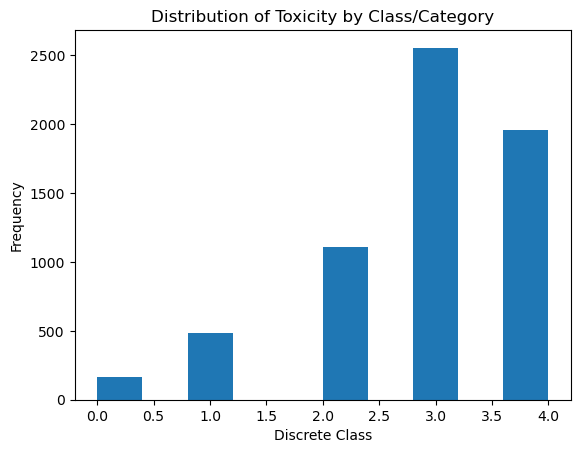

Accuracy of  logistic regression  for  rats: 0.480
Precision of  logistic regression  for  rats: 0.471
Recall of  logistic regression  for  rats: 0.480


<Figure size 640x480 with 0 Axes>

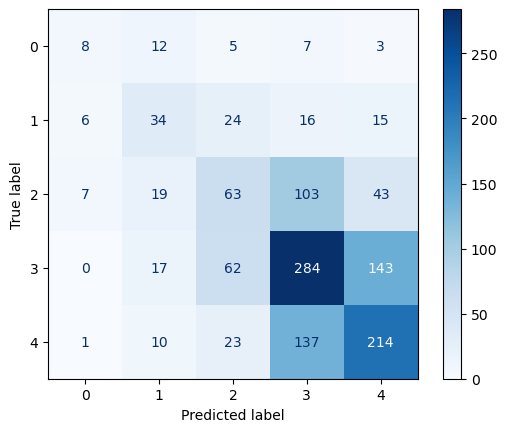

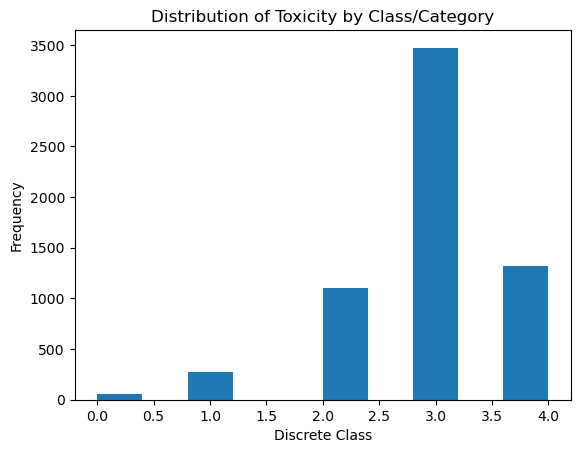

Accuracy of  logistic regression  for  mice: 0.636
Precision of  logistic regression  for  mice: 0.629
Recall of  logistic regression  for  mice: 0.636


<Figure size 640x480 with 0 Axes>

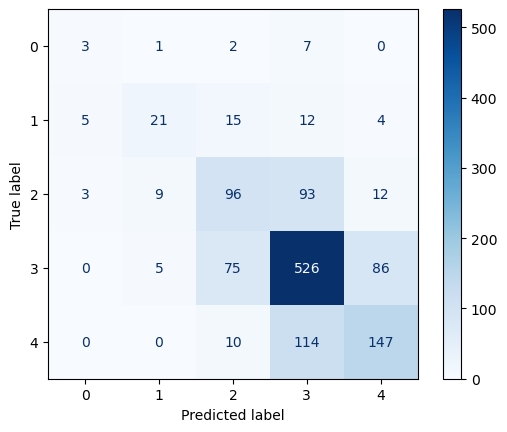

In [3]:
# Logistic Regression for Rats
data_rats = dataframe("Rats")
mols_rats = mol_smile(data_rats)
rat_fp, rat_mw, rat_yval = all_vals(mols_rats, data_rats)
X_rats =X_val(rat_fp)
rat_ld50 = ld50s(rat_yval, rat_mw)
Y_rats= Y_val(rat_ld50)
xtrain_rat, xtest_rat, ytrain_rat, ytest_rat = model(X_rats, Y_rats) 
y_pred_logreg_rat, logreg_model_rat = logreg(xtrain_rat, xtest_rat, ytrain_rat)
eval_model(ytest_rat,y_pred_logreg_rat, " logistic regression ", " rats")


#Logistic Regression for Mice
data_mice= dataframe("Mice")
mols_mice = mol_smile(data_mice)
mice_fp, mice_mw, mice_yval = all_vals(mols_mice, data_mice)
X_mice =X_val(mice_fp)
mice_ld50 = ld50s(mice_yval, mice_mw)
Y_mice=Y_val(mice_ld50)
xtrain_mice, xtest_mice, ytrain_mice, ytest_mice = model(X_mice, Y_mice)
y_pred_logreg_mice, logreg_model_mice = logreg(xtrain_mice, xtest_mice, ytrain_mice)
eval_model(ytest_mice, y_pred_logreg_mice, " logistic regression ", " mice")


In [4]:
category_counts_mice = pd.Series(Y_mice).value_counts().sort_index()
print("Actual:", category_counts_mice)
print("Expected (PredAOT mice):")
print("1: 67, 2: 282, 3: 1183, 4: 3413, 5: 1281")  #From Table 1
print("Max deviation:", abs(category_counts_mice - [67,282,1183,3413,1281]).max())

category_counts_rats = pd.Series(Y_rats).value_counts().sort_index()
print("Actual:", category_counts_rats)
print("Expected (PredAOT rats):")
print("1: 173, 2: 490, 3: 1103, 4: 2560, 5: 1912")  #From Table 1
print("Max deviation:", abs(category_counts_rats - [173,490,1103,2560,1912]).max())

Actual: 0      61
1     272
2    1101
3    3475
4    1317
Name: count, dtype: int64
Expected (PredAOT mice):
1: 67, 2: 282, 3: 1183, 4: 3413, 5: 1281
Max deviation: 82
Actual: 0     165
1     488
2    1108
3    2556
4    1961
Name: count, dtype: int64
Expected (PredAOT rats):
1: 173, 2: 490, 3: 1103, 4: 2560, 5: 1912
Max deviation: 49


Accuracy of  SVM  for  rats: 0.521
Precision of  SVM  for  rats: 0.519
Recall of  SVM  for  rats: 0.521
Accuracy of  SVM  for  mice: 0.605
Precision of  SVM  for  mice: 0.643
Recall of  SVM  for  mice: 0.605


<Figure size 640x480 with 0 Axes>

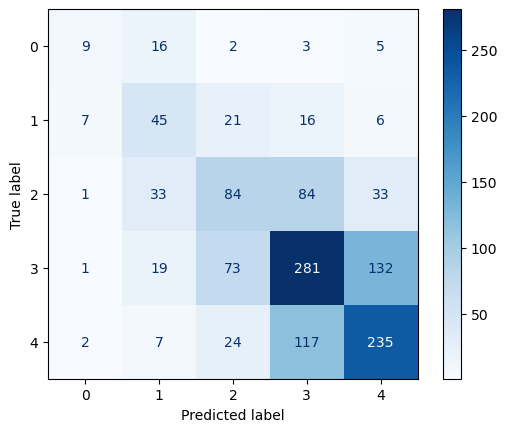

<Figure size 640x480 with 0 Axes>

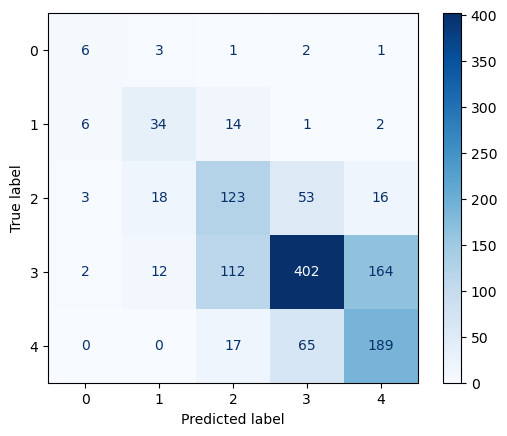

In [5]:
#SVM
def svm_model(X_train, X_test, y_train):
    clf = svm.SVC(class_weight='balanced') #set the class weight to balanced because data is skewed towards class 4, the model became more accurate and there were fewer false positives in class 4 
    #LinearSVC has a lower accuracy
    clf.fit(X_train, y_train)
    svm_pred=clf.predict(X_test)
    return svm_pred

#Rats
y_pred_svm_rat = svm_model(xtrain_rat, xtest_rat, ytrain_rat)
eval_model(ytest_rat,y_pred_svm_rat, " SVM ", " rats")

#Mice
y_pred_svm_mice = svm_model(xtrain_mice, xtest_mice, ytrain_mice)
eval_model(ytest_mice,y_pred_svm_mice, " SVM ", " mice")

#parts of code sourced from https://scikit-learn.org

Accuracy of  KNN  for  rats: 0.506
Precision of  KNN  for  rats: 0.499
Recall of  KNN  for  rats: 0.506
Accuracy of  KNN  for  mice: 0.643
Precision of  KNN  for  mice: 0.640
Recall of  KNN  for  mice: 0.643


<Figure size 640x480 with 0 Axes>

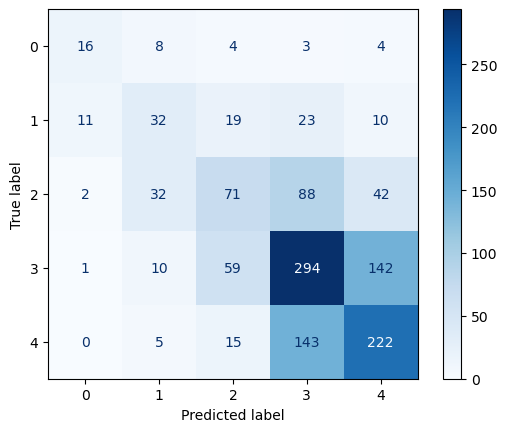

<Figure size 640x480 with 0 Axes>

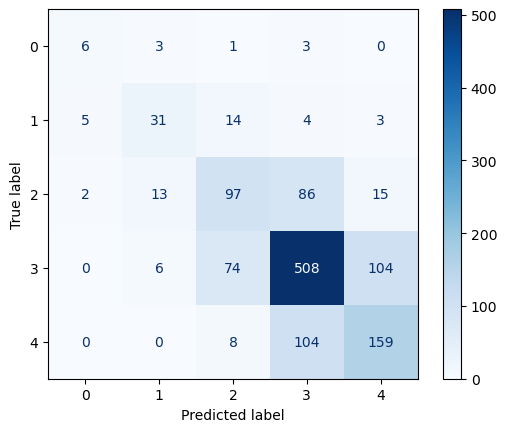

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

#KNN
def knn_model(X_train, X_test, y_train):
    #scaler = StandardScaler()
    #scaler.fit(X_train)
    #X_train_scaled = scaler.transform(X_train)
    #X_test_scaled = scaler.transform(X_test) #tried to preprocess data for KNN, got a lower precision for the rat dataset than without scaling
    clf = sklearn.neighbors.KNeighborsClassifier()
    clf.fit(X_train, y_train)
    knn_pred=clf.predict(X_test)
    return knn_pred

#Rats
y_pred_knn_rat = knn_model(xtrain_rat, xtest_rat, ytrain_rat)
eval_model(ytest_rat,y_pred_knn_rat, " KNN ", " rats")

#Mice
y_pred_knn_mice = knn_model(xtrain_mice, xtest_mice, ytrain_mice)
eval_model(ytest_mice,y_pred_knn_mice, " KNN ", " mice")

#parts of code sourced from https://scikit-learn.org

[07:57:52] Explicit valence for atom # 0 N, 4, is greater than permitted
[07:57:52] Can't kekulize mol.  Unkekulized atoms: 9
[07:57:53] Can't kekulize mol.  Unkekulized atoms: 4
[07:57:53] Can't kekulize mol.  Unkekulized atoms: 4


Accuracy of  logistic regression  for  clinical trials: 0.916
Precision of  logistic regression  for  clinical trials: 0.900
Recall of  logistic regression  for  clinical trials: 0.916
Accuracy of  KNN  for  clinical trials: 0.909
Precision of  KNN  for  clinical trials: 0.862
Recall of  KNN  for  clinical trials: 0.909
Accuracy of  SVM  for  clinical trials: 0.916
Precision of  SVM  for  clinical trials: 0.884
Recall of  SVM  for  clinical trials: 0.916


<Figure size 640x480 with 0 Axes>

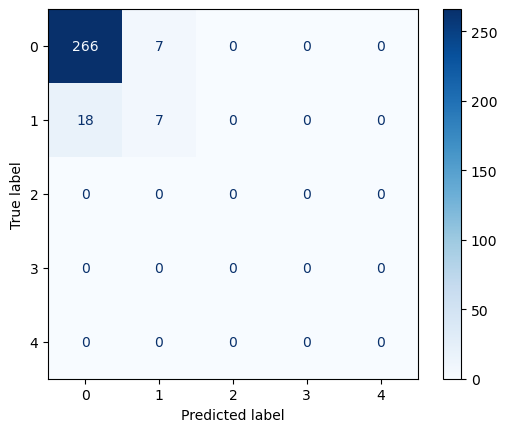

<Figure size 640x480 with 0 Axes>

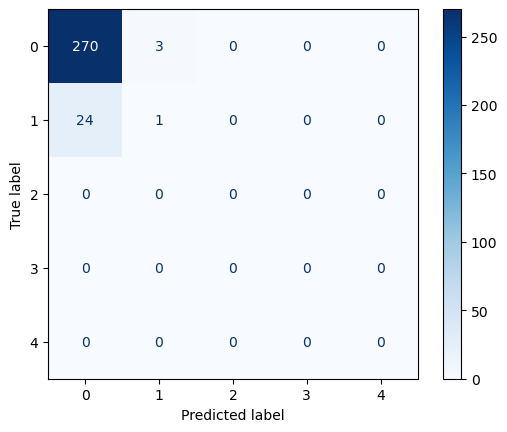

<Figure size 640x480 with 0 Axes>

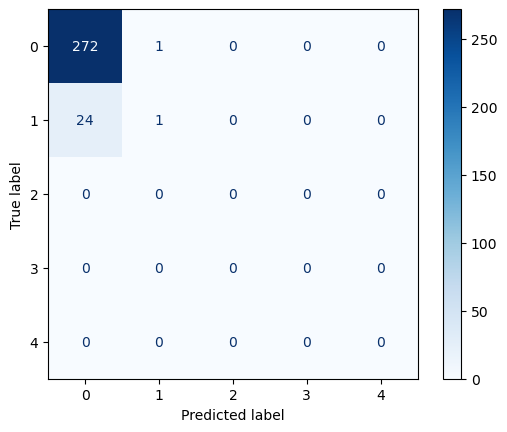

In [7]:
#For Clintox data from Accurate clinical toxicity prediction using multi-task deep neural nets and contrastive molecular explanations paper

clintox_data = pd.read_csv("clintox.csv") 
clintox_data=clintox_data[clintox_data['smiles'].notna()]
clintox_data=clintox_data[clintox_data['CT_TOX'].notna()]
smiles_list = clintox_data.iloc[:,0]
mols = [Chem.MolFromSmiles(s) for s in smiles_list] 
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024) 

fingerprints = []
Y=[] #value of 0 is non-toxic, 1 is toxic (failed clinical trial); skewed
for i, mol in enumerate(mols):
    if mol is not None:
        fp = gen.GetFingerprint(mol)  #generate fingerprint for each mol
        fingerprints.append(fp)
        Y.append(clintox_data.iloc[i, 2]) 
        
def fp_to_array(fp):
    array = np.zeros((fp.GetNumBits(),), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, array) 
    return array.tolist()

X = [fp_to_array(fp) for fp in fingerprints]
       
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) 

clf_log_clin = LogisticRegression(max_iter=5000) 


clf_log_clin.fit(X_train, y_train)
y_pred_log = clf_log_clin.predict(X_test)

eval_model(y_test,y_pred_log, " logistic regression ", " clinical trials")

clf_knn_clin = sklearn.neighbors.KNeighborsClassifier()
clf_knn_clin.fit(X_train, y_train)
knn_pred=clf_knn_clin.predict(X_test)
eval_model(y_test,knn_pred, " KNN ", " clinical trials")

clf_svm_clin = svm.SVC() 
clf_svm_clin.fit(X_train, y_train)
svm_pred=clf_svm_clin.predict(X_test)
eval_model(y_test,svm_pred, " SVM ", " clinical trials")

#from sklearn.metrics import recall_score, balanced_accuracy_score (the paper uses the sensitivity, specificity, and balanced accuracy to evaluate their model)
#sensitivity = recall_score(y_test, y_pred)

#balanced_acc = balanced_accuracy_score(y_test, y_pred)

#print(f"Sensitivity: {sensitivity:.4f}")
#print(f"Balanced Accuracy: {balanced_acc:.4f}")